# Besedni zaklad na spletnem portalu 4chan
### Projektna naloga

## Priprava podatkov

Najprej uvozimo podatke, ki jih nameravamo uporabljati. V tem primeru imamo poleg podatkovne množice, generirane s *scrapery.py*, še *lexicon*, pridobljen [tukaj](http://www.lexique.org/?page_id=250), frekvenčni leksikon, med drugim baziran na objavah iz Twitterja. Le-tega uporabimo kot osnovnico naših frekvenčnih leksikonov. Naša druga zunanja podatkovna množica je seznam angleških obscenih besed. Prirejena je po [tem](https://data.world/wordlists/dirty-naughty-obscene-and-otherwise-bad-words-in-english) viru - v predprocesiranju smo obdržali le enobesedne vulgarnice.

Poleg tega definiramo pomožna seznama *boards* ter *countries*, ki iz objav pobereta seznam boardov in držav izvora posameznih objav. Koristili bota pri kasnejših analizah.

Uporabljam podatke postopoma zajete med nočjo 11.2.2021 in popoldnevom naslednjega dne (skozi dan je bilo dodanih nekaj boardov).

In [459]:
import pandas as pd
import numpy as np

low_memory=False
pd.options.display.max_rows = 30
%matplotlib inline


posts = pd.read_csv("data/datasets/total_dataset.csv")
lexicon = pd.read_csv("data/datasets/lexique_english.csv")[["Word", "TwitterFreqPm"]].rename(columns={"TwitterFreqPm" : "FreqPM"})

boards = list(posts.board.unique())
countries = list(posts.country_name.unique())

with open("data/datasets/profanity.csv", "r") as f:
        profanity = f.read().split('\n')
    


/Users/jure/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Kot vidimo, nam v tej obliki podatki ne povejo prav veliko, zato bomo kar hitro začeli z obravnavo frekvenčnih leksikonov.

In [460]:
posts

,no,resto,now,country_name,com,replies,board
0,307559833,0,02/10/21(Wed)22:38:12,Commie,what the hell is wrong with the tiktok black a...,2.0,pol
1,307559956,307559833,02/10/21(Wed)22:39:23,United States,fake amp gay slide thread,NaN,pol
2,307559978,307559833,02/10/21(Wed)22:39:37,Commie,she no white tik tok no problem,NaN,pol
3,307553218,0,02/10/21(Wed)21:38:37,Canada,help me could a b rother help me out,17.0,pol
4,307555431,307553218,02/10/21(Wed)21:58:37,United States,NaN,NaN,pol
...,...,...,...,...,...,...,...
206110,216228239,216228103,02/11/21(Thu)12:43:15,NaN,sneed,NaN,a
206111,216229527,216228103,02/11/21(Thu)13:06:05,NaN,the part would have been way better if it was ...,NaN,a
206112,216229596,216228103,02/11/21(Thu)13:07:07,NaN,the only fun parts are josuke and the other in...,NaN,a
206113,216231238,216228103,02/11/21(Thu)13:36:19,NaN,who,NaN,a


Naš Twitter leksikon ima pričakovano obliko. Za posamezno besedo imamo njeno frekvenco na miljon besed.

In [461]:
lexicon

,Word,FreqPM
0,the,30240.5631
1,and,14144.8212
2,to,25419.6557
3,i,29597.6592
4,a,19787.7584
...,...,...
221319,ab-soul,0.1291
221320,ab-only,0.0646
221321,ab-focused,0.0000
221322,ab-extradition,0.0323


## Profanost posameznih boardov v primerjavi s povprečjem 4chana in Twitterja

Da bo naše delo z leksikoni lažje, definiramo tri funkcije. Prva nam iz poljubnega podatkovnega podokvirja objav ustvari leksikon. Ta ima tri stolpce: *Word*, posamezne besede, *AbsFreq*, ki, nepresenetljivo, vsebuje prešteto število besed ter *FreqPM*, ki, kakor v našem standardnem leksikonu, vsebuje frekvenco dane besede na miljon besed. Drugi dve funkciji sta v resnici le okrajšavi prve in nam omogočata hitro pridobitev leksikona za dan board in državo.

In [462]:
def make_lexicon_from(frame):
    lex = {}
    word_count = 0
    
    for post in frame["com"]:
        try:
            for word in post.split():
                if lex.get(word, None) == None:
                    lex[word] = 1
                else:
                    lex[word] += 1
                word_count += 1
        except Exception:
            pass
        
    r_frame = pd.DataFrame(list(lex.items()), columns=["Word", "AbsFreq"])
    r_frame["FreqPM"] = r_frame["AbsFreq"].apply(lambda x: (x * (10 ** 6)) / word_count)

    return r_frame

def board_lexicon(board):
    return make_lexicon_from(posts[posts.board == board])

def country_lexicon(country):
    return make_lexicon_from(posts[posts.country_name == country])
    

Glavna podmnožica, ki jo obravnavamo, je kar zbirka vseh objav iz vseh boardov. Za to definiramo poseben leksikon

In [463]:
chan_lexicon = make_lexicon_from(posts).sort_values(by="FreqPM", ascending=False)
chan_lexicon

,Word,AbsFreq,FreqPM
1,the,108100,35868.350875
24,a,71859,23843.328636
69,i,71599,23757.058782
33,to,66191,21962.645817
8,and,60416,20046.459635
...,...,...,...
50018,coronoa,1,0.331807
50019,kyuusei,1,0.331807
50021,ballkan,1,0.331807
50022,broadetty,1,0.331807


Kot primer: frekvenčna porazdelitev 15 najbolj pogostih besed v /po/, boardu za origami in papirno ustvarjanje in v naši osnovnici osnovani na Twitterju. Pričakovano še nismo prišli do skoraj nobenega samostalnika.

In [464]:
board_lexicon("po").sort_values(by="FreqPM", ascending=False).head(15)

,Word,AbsFreq,FreqPM
221,i,4609,37066.823223
27,the,4231,34026.845098
1,to,3074,24721.938509
142,it,2725,21915.186219
34,a,2687,21609.579952
84,you,2524,20298.689914
8,and,2330,18738.489501
22,of,1808,14540.424471
69,for,1556,12513.772388
17,is,1536,12352.926984


In [465]:
lexicon.sort_values(by="FreqPM", ascending=False).head(15)

,Word,FreqPM
0,the,30240.5631
3,i,29597.6592
2,to,25419.6557
4,a,19787.7584
11,you,19386.1533
1,and,14144.8212
10,for,12432.0357
7,it,12362.3415
6,in,12206.1025
5,of,11594.8984


Eden izmed naših glavnih ciljev je karakterizacija podmnožic po profanosti. V ta namen definiramo par pomožnih funkcij: *subframe_containing_list_in* nam omogoča, da vzamemo podmnožico leksikona, ki vsebuje besede v danem seznamu. V praksi ga uporabimo, da vzamemo podmnožico leksikona profanih besed. Zato hitro definiramo *profane_lexicon*, ki vzame leksikon in vrne njegovo profano podmnožico. Naslednji dve funkciji nam omogočata grobo kategorizacijo profanosti danega leksikona - *total_freqPM* vrne skupno število besed na miljon danega leksikona (ki je včasih manjši od skupnega števila elementov, specifično se to zgodi v naši osnovni podatkovni množici s Twitterja), *total_profanity* pa uporabi prejšnjo, da izračuna število profanih besed na miljon v danem leksikonu.

In [466]:
def subframe_containing_list_in(frame, possibilities, attribute):
    return frame[frame[attribute].apply(lambda x: x in possibilities)]

def profane_lexicon(lexicon):
    return subframe_containing_list_in(lexicon, profanity, "Word")

def total_freqPM(lexicon):
    try:
        return sum(lexicon.FreqPM)
    except Exception:
        return None

def total_profanity(lexicon):
    return total_freqPM(profane_lexicon(lexicon))

<AxesSubplot:xlabel='Source'>

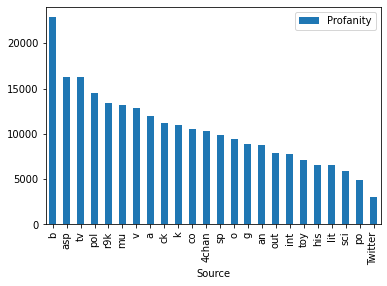

In [467]:
board_profanities = [total_profanity(board_lexicon(board)) for board in boards] + [total_profanity(chan_lexicon), total_profanity(lexicon)]

bp = pd.DataFrame.from_dict({"Source": boards + ["4chan", "Twitter"], "Profanity": board_profanities}).sort_values(by="Profanity", ascending=False)
bp.sort_values(by="Profanity", ascending=False).plot.bar(x="Source", y="Profanity")

Po pričakovanjih, dominira /b/ (Random) z več kot 20000 vulgarnostmi na milijon besed. 4chan sam po sebi jih ima malo več kot 10000/milijon. Vsi boardi pa močno dominirajo Twitter z manj kot 5000 vulgarnosti na milijon. Zanimivo na drugem mestu ni /pol/ (Politically Incorrect) po hipotezi, ampak /asp/ (Alternative Sports & Wrestling) ter /tv/ (Television & Film) - /pol/ je šele na 4. mestu. Prva predpostavka je tako delno potrjena - /b/ je močno slabši kot vsi ostali boardi, /pol/ pa je na še zmeraj visokem, a zmernejšem 4. mestu. Potrdili smo tudi hipotezo, da je register na 4chanu opazno bolj vulgaren, kot na naši osnovnici Twitter. Tudi na prvo žogo sodeč neškodljiv /po/ je skoraj dvakrat bolj profan od osnovnice.

## Profanost posameznih držav

4chan ima na nekaterih boardih majhne zastavice, ki kažejo na nacionalnost uporabnikov. Pozoren bralec je že tako ali tako zasledil nadaljevanje prejšnjega odseka v države - še funkcijo imamo pripravljeno. Oglejmo si najprej distribucijo naših objav.

In [494]:
country_sizes = posts.groupby("country_name").size().sort_values(ascending=False)
country_sizes.head(30)

country_name
United States         14539
United Kingdom         2973
Canada                 2530
Australia              1505
Brazil                 1260
Germany                1111
Sweden                  716
France                  648
Portugal                622
Mexico                  546
Finland                 499
Norway                  498
Argentina               464
Italy                   421
Poland                  382
Netherlands             366
New Zealand             272
Chile                   254
Russian Federation      249
Spain                   236
Ireland                 225
Denmark                 201
Indonesia               182
Japan                   167
Turkey                  166
Nazi                    151
Pirate                  149
Philippines             127
Greece                  125
Austria                 117
dtype: int64

Imamo torej 125 držav, od tega vodijo štiri angleško govoreče, sledita Brazilija in Nemčija. Omejili se bomo na države z najmanj 120 objavami. Na grafu se še bolj vidi, kako močno dominirajo Združene države ter druge angleško govoreče nacije.

<AxesSubplot:xlabel='country_name'>

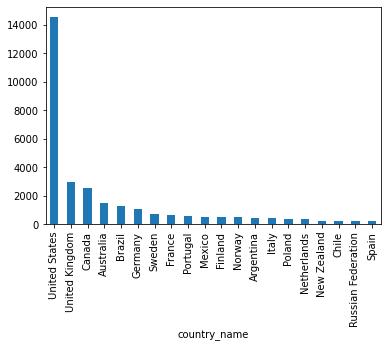

In [500]:
country_sizes.head(20).plot.bar()

Da preverimo profanost najprej naredimo podokvir objav, katerih država je neprazna, potem pa še preverimo, da ima dovolj objav. 

In [578]:
nposts_with_countries = posts[~posts.country_name.isnull()]
posts_from_big = posts_with_countries[posts_with_countries["country_name"].apply(lambda x: country_sizes[x] >= 120)]
posts_from_big

,no,resto,now,country_name,com,replies,board
1,307559956,307559833,02/10/21(Wed)22:39:23,United States,fake amp gay slide thread,NaN,pol
3,307553218,0,02/10/21(Wed)21:38:37,Canada,help me could a b rother help me out,17.0,pol
4,307555431,307553218,02/10/21(Wed)21:58:37,United States,NaN,NaN,pol
5,307555669,307553218,02/10/21(Wed)22:00:32,United States,rayshard brooks the guy who tried to taser cop...,NaN,pol
6,307556342,307553218,02/10/21(Wed)22:06:37,Australia,the archives of gif they had a riot general ru...,NaN,pol
...,...,...,...,...,...,...,...
113876,139323119,139321586,02/10/21(Wed)21:57:47,Brazil,brazilian women are the easiest in the world,NaN,int
113877,139323130,139321586,02/10/21(Wed)21:58:10,Brazil,NaN,NaN,int
113878,139323155,139321586,02/10/21(Wed)21:59:13,Brazil,it s just your,NaN,int
113879,139323165,139321586,02/10/21(Wed)21:59:29,Brazil,is it just me or is the janny pruning all braz...,NaN,int


Nato za vsako izmed držav po prej definirani funkciji izračunamo stopnjo vulgarnosti ter jo prikažemu na histogramu in tabeliramo.

<AxesSubplot:xlabel='Source'>

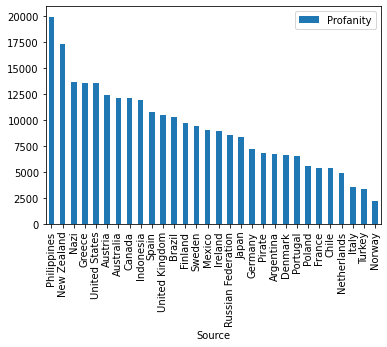

In [562]:
big_countries = country_sizes.head(30).index.array
country_profanities = [total_profanity(country_lexicon(country)) for country in big_countries]

cp = pd.DataFrame.from_dict({"Source": list(big_countries), "Profanity": country_profanities}).sort_values(by="Profanity", ascending=False)
cp.sort_values(by="Profanity", ascending=False).plot.bar(x="Source", y="Profanity")

Rezultati so zanimivi, veliko prednost imajo Filipinci in Novozelandci, na daljnem tretjem mestu pa so nacisti (Poleg držav, odvisnih od lokacije, si uporabniki lahko izberejo tudi druge vrste zastav. Kdo bi si bil mislil). Upoštevajmo še velikost populacije - uporabil bom *ppp* (profanity per population) ter *pp* (profanity percentage).
Prva je preprost kvocient profanosti / populacijo dane nacije, slednja pa gleda procent profanosti v skupini vseh velikih držav. Poleg tega imamo še *pppp* (profanity percentage per population), ki je prava Hegelianska sinteza *pp* in *ppp*. Je pa tu tudi zato, ker si avtor ni mogel pomagati in izpustiti tako priročne in prefinjejo prikladne priložnosti za ime še ene spremenljivke.

In [595]:
cp["pop"] = cp.Source.apply(lambda x: country_sizes[x])
cp["ppp"] = cp["Profanity"] / cp ["pop"]

skupna_profanost = sum(cp["Profanity"])
cp["pp"] = cp["Profanity"] / skupna_profanost

cp["pppp"] = cp["pp"] / cp["pop"]

cp.sort_values(by="pp", ascending=False)

,Source,Profanity,pop,ppp,pp,pppp
27,Philippines,19944.979367,127,157.047082,0.072176,0.000568
16,New Zealand,17302.259887,272,63.611250,0.062613,0.000230
25,Nazi,13627.254509,151,90.246719,0.049314,0.000327
28,Greece,13600.572656,125,108.804581,0.049217,0.000394
0,United States,13524.044390,14539,0.930191,0.048940,0.000003
29,Austria,12444.444444,117,106.362773,0.045034,0.000385
3,Australia,12105.804733,1505,8.043724,0.043808,0.000029
2,Canada,12096.418165,2530,4.781193,0.043774,0.000017
22,Indonesia,11895.321174,182,65.358908,0.043046,0.000237
19,Spain,10752.688172,236,45.562238,0.038911,0.000165


<AxesSubplot:xlabel='Source'>

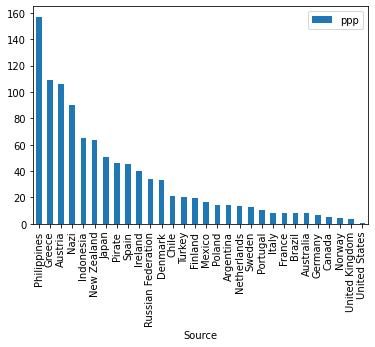

In [591]:
cp.sort_values(by="ppp", ascending=False).plot.bar(x="Source", y="ppp")

<AxesSubplot:xlabel='Source'>

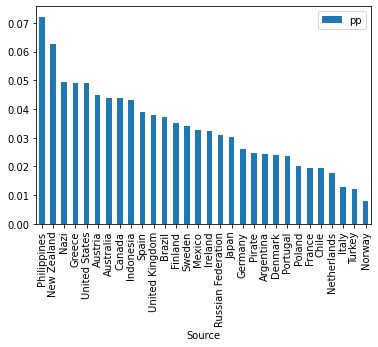

In [592]:
cp.sort_values(by="pp", ascending=False).plot.bar(x="Source", y="pp")

<AxesSubplot:xlabel='Source'>

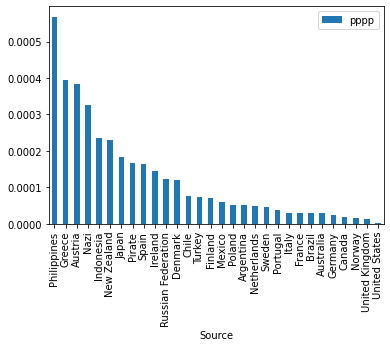

In [596]:
cp.sort_values(by="pppp", ascending=False).plot.bar(x="Source", y="pppp")

Podatki so zanimivi. V obeh prirejenih oblikah še zmeraj dominirajo Filipini, imamo pa ogromno odstopanje glede Američanov - čeprav so v *pp* na (ne)spoštljivem petem mestu, so v *ppp*, torej vulgarnosti na objavo v samem dnu! Vrednost *pppp* ima povsem enak vrstni red kot *ppp*, glede česar avtor ne najde kvalitetnega komentarja. 

## Niti 4-chana

Želimo si ogledati uspešnost posameznih niti objav. Naša delovna hipoteza glede le-teh je, da je profanost korelirana s popularnostjo. Za posamezno nit ustvarimo leksikon tako, da vzamemo podmnožico, ki referencira glavno objavo v niti, in s prejšnjo funkcijo naredimo leksikon. To naredita funkciji *get_whole_thread* in *make_thread_lexicon*. Nazadnje še z *get_thread_profanity* izračunamo stopnjo profanosti posamezne niti.

In [468]:
def get_whole_thread(frame, board, head_no):
    return frame[(frame["board"] == board) & ((posts["resto"] == head_no) | (posts["no"] == cid))]

def make_thread_lexicon(cbd, cid):
    return make_lexicon_from(get_whole_thread(posts, cbd, cid)).sort_values("FreqPM", ascending=False)

def get_thread_profanity(cbd, cid):
    return total_profanity(make_thread_lexicon(cbd, cid))

Za začetek samo vzamemo podmnožico glavnih objav - te so ravno tiste s poljem "resto" enakim 0.

In [475]:
threads = posts[(posts["resto"] == 0)].sort_values(by="replies", ascending=False)

Nato temu okvirju dodamo nov stolpec - izračunana stopnja profanosti.
**Opozorilo: naslednja celica se izvaja relativno dolgo.**

In [476]:
threads["profanity"] = np.vectorize(get_thread_profanity)(threads["board"], threads["no"])

Zdaj si lahko ogledamo odvisnost profanosti in števila odgovorov:

<AxesSubplot:xlabel='replies', ylabel='profanity'>

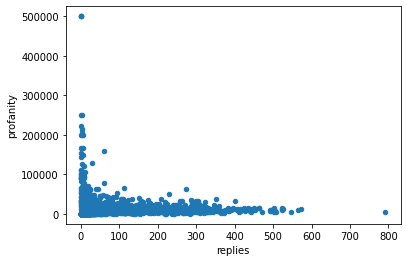

In [477]:
threads.plot.scatter(x="replies", y="profanity")

Imamo par oddaljencev, zato približamo.

<AxesSubplot:xlabel='replies', ylabel='profanity'>

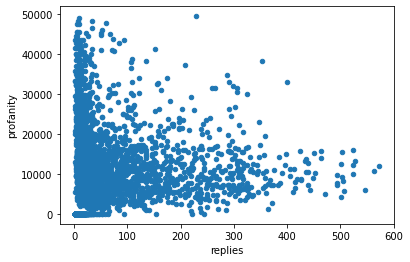

In [818]:
threads[(threads["replies"] < 600) & (threads["profanity"] < 50000)].plot.scatter(x="replies", y="profanity")

Za objave z veliko odgovori vidimo negativno korelacijo. Ker ima na 4chanu večina objav manj kot nekaj sto odgovorov (veliki se nahajajo v glavnem v počasnejših boardih, kjer se odgovori nabirajo dolgo), si oglejmo še, kaj se dogaja pri nitih z manj kot 50 odgovori.

<AxesSubplot:xlabel='replies', ylabel='profanity'>

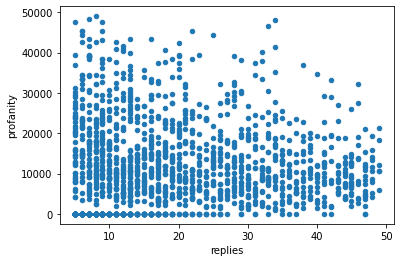

In [472]:
threads[(threads["replies"] < 50) & (threads["profanity"] < 50000)].plot.scatter(x="replies", y="profanity")

Še zmeraj vidimo rahlo negativno korelacijo. Sklepam, da je razlog za to dejstvo, da je pri objavah z majhnim številom odgovorov odstotek profanih števil potencialno lahko zelo visok. Če ima objava več kot le nekaj odgovorov je verjetnost, da ima odgovore s substanco večja. Na žalost pa moji trenutni analizi primankuje semantičnost, zato hipoteze ne morem raziskati naprej.

Smo pa ovrgli delovno hipotezo, da so hujše objave popularnejše, saj pozitivne korelacije ni bilo nikjer.

## Kako gre čas, vulgarneži

Raziskujemo stopnjo profanosti skozi čas dneva (v urah EST). Najprej si oglejmo, koliko objav je narejeno v posameznem času.

In [609]:
def extract_hour(time):
    t = time[13:15]
    if t[0] == 0:
        return int(t[1])
    else:
        return int(t)

timed_posts = posts
timed_posts["hour"] = posts["now"].apply(extract_hour)
timed_posts

,no,resto,now,country_name,com,replies,board,hour
0,307559833,0,02/10/21(Wed)22:38:12,Commie,what the hell is wrong with the tiktok black a...,2.0,pol,22
1,307559956,307559833,02/10/21(Wed)22:39:23,United States,fake amp gay slide thread,NaN,pol,22
2,307559978,307559833,02/10/21(Wed)22:39:37,Commie,she no white tik tok no problem,NaN,pol,22
3,307553218,0,02/10/21(Wed)21:38:37,Canada,help me could a b rother help me out,17.0,pol,21
4,307555431,307553218,02/10/21(Wed)21:58:37,United States,NaN,NaN,pol,21
...,...,...,...,...,...,...,...,...
206110,216228239,216228103,02/11/21(Thu)12:43:15,NaN,sneed,NaN,a,12
206111,216229527,216228103,02/11/21(Thu)13:06:05,NaN,the part would have been way better if it was ...,NaN,a,13
206112,216229596,216228103,02/11/21(Thu)13:07:07,NaN,the only fun parts are josuke and the other in...,NaN,a,13
206113,216231238,216228103,02/11/21(Thu)13:36:19,NaN,who,NaN,a,13


<AxesSubplot:xlabel='hour'>

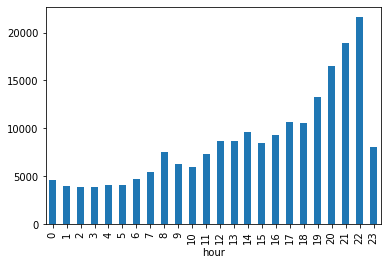

In [619]:
timed_post_num = timed_posts.groupby("hour").size()
timed_post_num.plot.bar()

Število objav se stopnjuje od polnoči do desetih zvečer, nato okrog enajstih bistveno upade. Zelo pričakovano, če sodimo po dejstvu, da ima večina uporabnikov naslednji dan pouk. Glede na odstotek Američanov med vsemi objavami se nam tudi ni škoda omejiti na predpostavko, da je čas, ki ga imamo tu enak kot čas v smislu časa v dnevu.

Naslednji korak je, kot pri državah, izolirati frekvenčne leksikone za razne ure v dnevu. Dodamo še eno pomožno funkcijo za konstrukcije leksikonov (če bi jo bralcu razkril že prej, ne bi mogel uživati v presenečenju še ene kategoričnosti, glede katere lahko obravnavamo profanost!). Analogno kot pri državah bomo obravnavali tudi relativno profanost.

<AxesSubplot:xlabel='Source'>

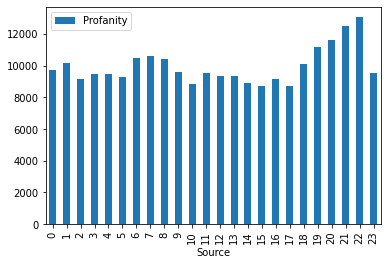

In [613]:
def time_lexicon(time):
    return make_lexicon_from(timed_posts[timed_posts["hour"] == time])

times = [x for x in range(0, 24)]
time_profanities = [total_profanity(time_lexicon(time)) for time in times]

tp = pd.DataFrame.from_dict({"Source": times, "Profanity": time_profanities})
tp.plot.bar(x="Source", y="Profanity")

In [620]:
tp["freq"] = tp.Source.apply(lambda x: timed_post_num[x])
tp["ppf"] = tp["Profanity"] / tp["freq"]

tp

,Source,Profanity,freq,ppf
0,0,9701.054700,4566,2.124629
1,1,10132.708821,4024,2.518069
2,2,9182.617693,3908,2.349697
3,3,9479.599316,3877,2.445086
4,4,9448.966227,4109,2.299578
5,5,9284.842254,4075,2.278489
6,6,10495.972636,4711,2.227971
7,7,10577.078439,5484,1.928716
8,8,10445.663002,7497,1.393312
9,9,9575.803898,6303,1.519245


<AxesSubplot:xlabel='Source'>

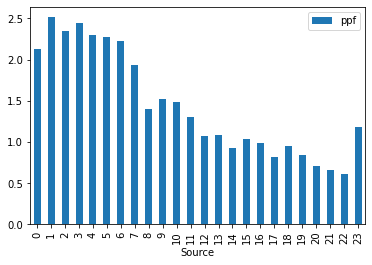

In [623]:
tp.plot.bar(x="Source",y="ppf")

Tu se omejujemo le na *ppf* (profanity per frequency) in opažamo, da so objave ponoči in v ranem jutru bistveno bolj profane kot kasneje. Sodeč po razporeditvi profanostih glede na državo je tak rezultat pričakovan, saj so Združene države relativno neaktivne glede profanosti.

## Klasifikacija teksta glede na board,

#### kjer protagonist skuša ugotoviti, katero sadje je bilo to, zdaj gnilo in neprepoznavno, ki ga drži v roki, preden je bilo gnilo in neprepoznavno.

V resnici uporabi metriko v prostoru frekvenčnih leksikonov. (le kdo bi si bil bil mislil) Najprej nastavimo, katere potencialne boarde bomo gledali. Za zdaj ga postavimo kar na seznam vseh board.

In [790]:
boards_to_check = boards

Razdalja leksikonov je evklidska glede na vrednosti frekvenc besed, ki so v obeh. Za dan korpus torej zgeneriramo njegov frekvenčni leksikon in izračunamo njegovo razdaljo do leksikonov za vsak board in vrnemo tistega z najmanjšo razdaljo. Imamo funkciji *find_closest_board* in *find_closest_board_by_text* - prva vzame leksikon, druga pa sam tekst. Skozi teste ugotavljam, da deluje relativno dobro za dovolj velik korpus (spodaj imamo primer, kjer vzamemo podmnožice nekega boarda), a posamezna objava nima dovolj besed, da bi jo lahko dobro karakterizirali. Če vzamemo objave iz danega boarda z *resto == 0*, to je tiste, ki začnejo dano nit objav, jih funkcija pravilno klasificira, razen /int/, klasificiran kot /pol/, za katero sklepam, da je problem v dejstvu, da je veliko objav tam v ne-angleščini, torej v resnici preverjamo le angleške objave, ki so (nepresenetljivo) zelo podobne tistim na /pol/. 

In [812]:
def lexicon_distance(lex1, lex2):
    common_indices = lex1.index.intersection(lex2.index)
    new_frame = common_indices.to_frame()
    new_frame["dist"] = (lex1["FreqPM"] - lex2["FreqPM"]) ** 2
    
    return sum(new_frame["dist"]) ** (1 / 2)

def make_lexicon_from_text(text):
    lex = {}
    word_count = 0
    
    for post in text:
        try:
            for word in post.split():
                if lex.get(word, None) == None:
                    lex[word] = 1
                else:
                    lex[word] += 1
                word_count += 1
        except Exception:
            pass
        
    r_frame = pd.DataFrame(list(lex.items()), columns=["Word", "AbsFreq"])
    r_frame["FreqPM"] = r_frame["AbsFreq"].apply(lambda x: (x * (10 ** 6)) / word_count)

    return r_frame

board_lexicons = {board : board_lexicon(board).sort_values(by="FreqPM", ascending=False).set_index("Word") for board in boards_to_check}

def find_closest_board(lexicon):
    lexicon = lexicon.sort_values(by="FreqPM", ascending=False).set_index("Word")
    d = {board : lexicon_distance(lexicon, lexi) for (board, lexi) in board_lexicons.items()}
    return sorted(d, key=d.get), min(d, key=d.get)
    
def find_closest_board_by_text(text):
    lex = make_lexicon_from_text(text)
    return find_closest_board(lex)
    

Primer dobro karakteriziranega korpusa.

In [816]:
find_closest_board(make_lexicon_from(posts[(posts["board"] == "out") & (posts["resto"] == 0)]))

(['out',
  'r9k',
  'po',
  'b',
  'g',
  'ck',
  'an',
  'mu',
  'k',
  'lit',
  'toy',
  'sci',
  'v',
  'o',
  'pol',
  'int',
  'asp',
  'tv',
  'a',
  'sp',
  'co',
  'his'],
 'out')

Primer napačno karakterizirane objave (Vzeta iz /pol/ gledajoč le na dolžino) - pravi board je karakteriziran kot drugi najmanj verjeten.

In [817]:
find_closest_board_by_text("how many shootings is enough how many more children need to die just so you fucking gun nuts can feel all powerful with your big black assault weapons just fucking face it the nd amendment was written by ignorant lunatics who had no idea about the problems we face today today we all have to be on high alert in case some autistic decides to reenact his cowadooty games and go shoot up a school when do we say enough is enough i propose a sensible solution you don't need bullets to kill a fucking deer every gun should only be capable of firing one bullet at a time and there should be a mandatory mechanism on every gun to prevent it from firing more than one bullet every hours if you small dicked gun nuts won't listen to reason and just give up your guns in the first place then we will have to take other measures to prevent more children from dying this is not there aren't roving gangs of barbarians at the gates and you can just abandon your macho hurr ima kill a home invader impotent fantasies because that literally never happens let me guess whenever you picture yourself confronting a man in your home at night you always picture a black man fucking racists all the guns in the world can't make your pathetic white dick any bigger so just give up already look at me i don't own guns or even knives and my house has never been broken into now why don't you join the rest of us in the fucking st century")

(['int',
  'o',
  'r9k',
  'po',
  'g',
  'k',
  'toy',
  'out',
  'ck',
  'mu',
  'an',
  'co',
  'b',
  'v',
  'sp',
  'asp',
  'tv',
  'lit',
  'sci',
  'a',
  'pol',
  'his'],
 'int')

Zanimiva bi bila primerjava te metode z Bayesovo klasifikacijo, ampak avtor potrebuje le dovolj točk, da projekt šteje kot opravljen, saj pod tem pogojem že ima dovolj skupnih točk za 10, hkrati pa je zaspan.

## Povzetek, zahvali in opravičili

### Povzetek

Spomnimo se delovnih hipotez in jih komentirajmo:
1. /b/ in /pol/ sta slabša v vseh metrikah kot ostali boardi
2. Vsi boardi so slabši od vsakdanjega registra
3. Hujše objave so popularnejše
4. Obstaja vsaj en board, ki ni usrana luknja

Prva hipoteza je definitivno presenetila - res je, da je /b/ neprimerljivo slabši kot vsi ostali boardi, ampak po drugi strani je veliko več slabših boardov, kot bi si človek mislil, /pol/ pa je šele na četrtem mestu. Druga hipoteza je potemtakem povsem potrjena - povprečna vulgarnost 4chana je več kot dvakrat višja od naše osnovnice podatkov. Zopet zanimiva je tretja, saj smo ugotovili, da je med vulgarnostjo objave in njeno popularnostjo kvečjemu negativna korelacija, vsaj po metodah trenutne analize. Četrta hipoteza je tudi ovržena. Vsaj izmed boardov, ki smo jih analizirali, avtor ne vidi nobenega vrednega obiska zunaj morbidnega zanimanja za potencialno pet minut, preden se začne glavobol. Poleg na začetku postavljenih hipotez smo raziskali tudi profanost glede na državo in med drugim ugotovili, da ima 4chan poleg držav tudi opcijo nacistične zastave, katera glede profanosti presenetljivo ni na prvem mestu in da imajo Združene Države bistveno najmanj profanosti na posamezno objavo. Raziskali smo aktivnost in profanost skozi dan in ugotovili, da se dobro prilega hipotezi, da spletno stvar uporabljajo šolarji, glede na strm padec aktivnosti okoli 23. ure - po drugi strani je profanost najvišja v nočnih urah. Dodatna analiza, ki bi upoštevala različne časovne pasove bi bila zanimiva in jo puščam kot nalogo za ocenjevalca. Končali smo s poskusom klasifikacije teksta glede na board - to je, da za dano objavo oz. korpus le-teh najdemo board, v katerega se najbolj prilega, gledoč na naše frekvenčne leksikone. Podvig je delno uspešen - deluje za dovolj bogate korpuse teksta - a se kar močno zatakne pri pomanjkanju gradiva.

### Opravičili in zahvali

Avtor se za naprej in za nazaj opravičuje za kakršnekoli narobe postavljene vejice, ter občasno neformalnost v pisanju. Le-ti sta produkt dejstva, da je pretežno nočno bitje in mu rahlo primanjkuje spanca, pa tudi izpostavljenosti entiteti, ki je 4chan, še posebej v luči dejstva trenutnega političnega stanja v Ameriki, ki ga še dodatno napihuje. Hkrati se zahvaljuje samemu sebi, da si je izbral dovolj zanimivo temo, da je projekt dejansko spravil v obstoj in se na poti naučil stvar ali dve o analizi podatkov, še posebej glede tekstovne analize. Avtor se zahvaljuje tudi ocenjevalcu za njegov čas in dobro delo in upa, da mu je uspel vsaj malo polepšati izkušnjo ocenjevanja. Avtor je za pritožbe (in komplimente) (skoraj) vedno na voljo. Lep pozdrav.